In [2]:
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import obspy
import matplotlib.patheffects as pe
import matplotlib.ticker as ticker
import calendar
from matplotlib.patches import Rectangle
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from shapely.geometry import box
import geopandas
import cmcrameri.cm as cmc
from cartopy.io import img_tiles
import os
import cartopy.crs as ccrs
from math import floor
import matplotlib
if os.name == 'nt':
    matplotlib.rc('font', family='Arial')
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc('font', family='DejaVu Sans')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:



def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.2, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [pe.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [pe.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)


def cm_plotter(ax,creepmeters_list,gdf,extent,color,shift):
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add Fault geometries
    ax.add_geometries(gdf.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
    # Add gridlines with specific label font sizes
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
    gl.ylabel_style = {'size': 14}

    # Add annotation with an arrow and transform
    for i in range(len(creepmeters_list)):
        face_color = color['creepmeter'][creepmeters_list['Creepmeter_abbrv'].iloc[i]]
        # Default xytext offset
        if shift == 'horizontal':
            # Adjust xytext for specific creepmeter abbreviations
            if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['XRSW', 'XTA1','XHSW', 'C461','CWN1/CWC3','CRR1','XMM1']:
                xytext_lon = creepmeters_list['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
            else:
                xytext_lon = creepmeters_list['Longitude'].iloc[i] + 0.1
            xytext_lat = creepmeters_list['Latitude'].iloc[i]
        if shift == 'vertical':
            xytext_lon = creepmeters_list['Longitude'].iloc[i] 
            xytext_lat = creepmeters_list['Latitude'].iloc[i] - 1
        
        
        
        ax.annotate(
            creepmeters_list['Creepmeter_abbrv'].iloc[i], 
            xy=(creepmeters_list['Longitude'].iloc[i], creepmeters_list['Latitude'].iloc[i]),
            xytext=(xytext_lon, xytext_lat), 
            arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
            fontsize=8, ha='center', va='center',
            transform=ccrs.PlateCarree()  # Make sure coordinates are correct
        )
        # Scatter points for creepmeters
        ax.scatter(
            creepmeters_list['Longitude'].iloc[i], 
            creepmeters_list['Latitude'].iloc[i], 
            color=face_color, 
            edgecolor='black', 
            s=100, 
            zorder=100, 
            transform=ccrs.Geodetic()
        )
        scale_bar(ax, ccrs.PlateCarree(), 100)
    return





def ymd_to_ydec(ST):
    y = int(ST.strftime("%Y"))
    dt_starter = dt.datetime(y,1,1,0,0,0)
    diff = (ST.replace(tzinfo=None)-dt_starter)/dt.timedelta(days=1)
    isleapyear = calendar.isleap(y)
    if isleapyear == True:
        diff_dec = diff/366
    else:
        diff_dec = diff/365
    date_dec = y+diff_dec
    return date_dec





def ce_summary_plot(creep_catalogue,instrument_database,region,save_name,shift,creepmeters_ls_list,creepmeters_ls,cmap,cm_map_list,gdf):
    hollister_extent = [-121.75,-121.0,36.5,37.0]
    hayward_extent = [-122.4,-121.8,37.5,38]
    parkfield_extent = [-120.75,-120.1,35.65,36.1]
    salton_sea_extent = [-116.25,-115.25,32.5,33.5]
    pakistan_extent = [61, 78, 23, 38]
    turkey_extent = [26.0, 45.0, 36.0, 42.0]


    region_CMs = instrument_database[instrument_database["Sub_region_map"]==region]
    file_codes = list(region_CMs["File_code"])
    order = list(region_CMs['Creepmeter_abbrv'].drop_duplicates())
    events_region = creep_catalogue[creep_catalogue["sub_region_maps"]==region]

    network = np.unique(events_region["Network"])
    events_region.sort_values(by="Latitude",inplace=True,ascending=False)
    events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
    events_region['Sampling rate'] = events_region['Sampling rate, mins'].astype(str)+' min'
    try:
        slicedCM = cmap(np.linspace(0, 1, len(creepmeters_ls_list)))
    except:
        slicedCM = cmap(np.linspace(0, 1, 2))

    fig = plt.figure(figsize=(17, 14))

    ax1= plt.subplot(3, 2, 1, projection=ccrs.PlateCarree())
    # Create an instance of GoogleTiles
    # google_tiles = img_tiles.GoogleTiles(style='satellite')
    # Add the Google Tiles to the axis with a lower zoom level
    # ax1.add_image(google_tiles, 10)

    # Initialize OpenStreetMap tiles
    osm = img_tiles.OSM()

    # Add OpenStreetMap tiles to the plot
    ax1.add_image(osm, 10)  # Zoom level of 8  


    if region == 'Hollister':
        extent = hollister_extent
        color_dict = {'creepmeter':{'XSH1':rgb2hex(slicedCM[0]),
                                    'XSJ2/3':rgb2hex(slicedCM[1]),
                                    'XSJ2':rgb2hex(slicedCM[1]),
                                    'XSJ3':rgb2hex(slicedCM[1]),
                                    'XHR1/2/3':rgb2hex(slicedCM[2]),
                                    'XHR1':rgb2hex(slicedCM[2]),
                                    'XHR2':rgb2hex(slicedCM[2]),
                                    'XHR3':rgb2hex(slicedCM[2]),
                                    'CWN1/CWC3':rgb2hex(slicedCM[4]),
                                    'CWC3':rgb2hex(slicedCM[3]),
                                    'CWN1':rgb2hex(slicedCM[4]),
                                    'FXC1':rgb2hex(slicedCM[5]),
                                    'XMR1':rgb2hex(slicedCM[6]),
                                    }}
    elif region == 'Hayward':
        extent = hayward_extent
        color_dict = {'creepmeter':{'CPP1':rgb2hex(slicedCM[0]),
                                    'CTM1':rgb2hex(slicedCM[1]),
                                    'COZ1':rgb2hex(slicedCM[2]),
                                    'CHP1':rgb2hex(slicedCM[3]),
                                    'CFW1':rgb2hex(slicedCM[4])}}
    elif region =='Parkfield':
        extent = parkfield_extent
        color_dict = {'creepmeter':{'XSC1':rgb2hex(slicedCM[0]),
                                    'XMM1':rgb2hex(slicedCM[1]),
                                    'XMD1':rgb2hex(slicedCM[2]),
                                    'XVA1':rgb2hex(slicedCM[3]),
                                    'XRSW':rgb2hex(slicedCM[4]),
                                    'XPK1/2':rgb2hex(slicedCM[5]),
                                    'XPK1':rgb2hex(slicedCM[5]),
                                    'XPK2':rgb2hex(slicedCM[5]),
                                    'XTA1':rgb2hex(slicedCM[6]),
                                    'XHSW':rgb2hex(slicedCM[7]),
                                    'WKR1':rgb2hex(slicedCM[8]),
                                    'CRR1':rgb2hex(slicedCM[9]),
                                    'XGH1':rgb2hex(slicedCM[10]),
                                    'C461':rgb2hex(slicedCM[11]),
                                    'X461':rgb2hex(slicedCM[12])}}
    elif region == 'SoCal':
        extent  =salton_sea_extent
        color_dict = {'creepmeter':{'DU30':rgb2hex(slicedCM[0]),
                                    'SU30':rgb2hex(slicedCM[1]),
                                    'RR45':rgb2hex(slicedCM[2])}}
    elif region == 'Chaman_Fault':
        extent = pakistan_extent
        color_dict = {'creepmeter':{'CHA1':rgb2hex(slicedCM[0])}}  
      
    
        
    # Add natural earth features for oceans and lakes
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face', facecolor='lightblue')
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face', facecolor='lightblue')
    # Add the land with pale sage green color
    pale_sage_green = '#D0E8D0'  # Very pale sage green color
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face', facecolor=pale_sage_green)

    # Add the features to the map
    ax1.add_feature(ocean, zorder=0)  # Add oceans first
    ax1.add_feature(lakes, zorder=1)  # Add lakes
    ax1.add_feature(land, zorder=0)   # Add land with pale sage green

    # Add coastlines and other features if desired
    ax1.coastlines(resolution='50m')
    if region == 'Chaman_Fault':
        # Load the Natural Earth countries shapefile
        world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

        # Filter for Pakistan
        pakistan = world[world.name == 'Pakistan']

        # Add the outline of Pakistan
        pakistan.boundary.plot(ax=ax1, color='red', linewidth=2, transform=ccrs.PlateCarree())
    cm_plotter(ax1,cm_map_list,gdf,extent,color_dict,shift)
    

    ax2=plt.subplot(3,2,2)
    creepmeters_ls_list.reset_index(inplace=True,drop=True)    
    
    for i in range(len(creepmeters_ls_list)):
        boolarr = np.where(creepmeters_ls['Creepmeter_abbrv']==creepmeters_ls_list[i])[0]
        selected = creepmeters_ls.loc[boolarr]

        sample_freqs = [1,2,5,10,30,60]
        hatchings = ['*','O','||','++','.','XX']
        for j in range(len(selected)):
            duration = selected['diff'].iloc[j].days/365

            fcolour = color_dict['creepmeter'][selected['Creepmeter_abbrv'].iloc[j]]
            bool_hatch = np.where(sample_freqs==selected['Sampling rate, mins'].iloc[j])[0][0]
            hatch_style = hatchings[bool_hatch]
            y = ymd_to_ydec(selected['Start Time'].iloc[j])
            plt.broken_barh([(y,duration)],(i,0.5),facecolors=fcolour,\
                            edgecolors='black',hatch=hatch_style,zorder=i+1)

            
    sampling_freq_all = np.unique(region_CMs['Sampling rate, mins'])
    for k in range(len(sampling_freq_all)):
        bool_hatch = np.where(sample_freqs==sampling_freq_all[k])[0][0]
        hatch_style = hatchings[bool_hatch]
        ax2.add_patch(Rectangle((2024,0.25),0,0, fc ='white',  ec ='black',zorder=-1,hatch=hatch_style,\
                                label='{k} min'.format(k=sampling_freq_all[k])) )
    tick_locations = list(np.linspace(0.25,i+.25,i+1))
    plt.ylim([i+0.5,0])

    plt.yticks(tick_locations,list(creepmeters_ls_list),fontsize=12)

    plt.xticks(fontsize=12,rotation=45)
    
    plt.ylabel('Creepmeter',fontsize=14)
    left,right = ax2.get_xlim()
    plt.xlim(left,right)
    for axis in [ax2.xaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax2.legend(title='Sampling rate')

    ax3=plt.subplot(3,2,3)
    for i in range(len(file_codes)):
        print(file_codes[i])
        for j in range(len(network)):
            try:
                path = "../../Data/{p}/SAC/{q}.SAC".format(p=network[j],q =file_codes[i])
                st = obspy.read(path)
                tr = st[0]
                #tr.interpolate(sampling_rate=tr.stats.sampling_rate)
                tm = tr.times("utcdatetime")
                creep = tr.data
                sample_rate =  round(tr.stats.delta)/60
                tm_dt = []
                for w in range(len(tm)):
                    tm_new = tm[w].datetime
                    tm_dt.append(tm_new)
                file_loc = np.where(instrument_database["File_code"]==file_codes[i])

                #label = instrument_database["Creepmeter_abbrv"].loc[file_loc[0][0]] + ": " + \
                    #str(instrument_database["Sampling rate, mins"].loc[file_loc[0][0]]) + "mins"  
                
                if instrument_database["Sampling rate, mins"].loc[file_loc[0][0]] ==10:
                    foreground='grey'
                else:
                    foreground = 'black'
                ax3.plot(tm_dt,creep,color=color_dict['creepmeter'][instrument_database['Creepmeter_abbrv'].loc[file_loc[0][0]]],
                         linewidth=2)#,path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])

            except FileNotFoundError:
                dummy=10
    
    
    CMs = list(region_CMs['Creepmeter_full_name'].drop_duplicates())
    #print(CMs)
    CM_colours = list(region_CMs['Colour_maps3'].drop_duplicates())
    for k in range(len(creepmeters_ls_list)):
        ax3.plot([],[],color=color_dict['creepmeter'][creepmeters_ls_list[k]],linewidth=1,label = creepmeters_ls_list[k])#,
                 #path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
            
    ax3.set_ylabel("Displacement, mm",fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)
    ax3.legend()



    sliced_palette = cmap(np.linspace(0, 1, 6))
    palette_new = {'1 min': rgb2hex(sliced_palette[0]), '2 min':rgb2hex(sliced_palette[1]),'5 min':rgb2hex(sliced_palette[2]),
               '10 min': rgb2hex(sliced_palette[3]),'30 min':rgb2hex(sliced_palette[4]), '60 min': rgb2hex(sliced_palette[5])}

    ax4 = plt.subplot(3,2,4)
    sns.countplot(events_region, x="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,order=order)
    ax4.set_xlabel('Creepmeters',fontsize=14)
    ax4.set_ylabel('Number of events',fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)

    ax5 = plt.subplot(3,2,5)
    sns.boxplot(data=events_region, x="Displacement, mm", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,\
                order=order,flierprops={"marker": "o"})
    ax5.set_ylabel('Creepmeters',fontsize=14)
    ax5.set_xlabel('Displacement, mm',fontsize=14)
    ax5.set_xscale('log')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    ax6 = plt.subplot(3,2,6)
    sns.boxplot(data=events_region, x="Duration, hrs", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,\
                order=order,flierprops={"marker": "o"})
    ax6.set_xscale('log')
    ax6.set_ylabel('Creepmeters',fontsize=14)
    ax6.set_xlabel('Duration, hrs',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    fig.tight_layout()
    fig.text(0.02,0.97,'a)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.51,0.97,'b)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.02,0.65,'c)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.51,0.65,'d)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.02,0.33,'e)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.51,0.33,'f)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.savefig("../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.pdf".format(k=save_name))
    fig.savefig("../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.png".format(k=save_name))
    plt.show()


    return

In [3]:
creepmeters = pd.read_excel('../../Data/creepmeter_lookup_and_processing_progress.xlsx',index_col=0)
Cali = creepmeters.drop(creepmeters[creepmeters["Region"]!="California"].index)
Cali.drop_duplicates(subset="Creepmeter_abbrv",inplace=True)
Pak = creepmeters.drop(creepmeters[creepmeters["Region"]!="Pakistan"].index)


Turk = creepmeters.drop(creepmeters[creepmeters["Region"]!="Turkiye"].index)
Turk.drop_duplicates(subset="Creepmeter_abbrv",inplace=True)
gdf_Asia = geopandas.read_file("../../Data/GIS_Files/AFEAD_v2022/AFEAD_v2022.shp")
Turk_cropped = Turk.copy(deep=True)
Turk_cropped["Creepmeter_abbrv"].loc[2]="INW1/ISW1/WSZ1"
Turk_cropped.drop([4,5],inplace=True)



gdf = geopandas.read_file("../../Data/GIS_Files/Shapefile/QFaults.shp")
gdf.drop(gdf[gdf.Location!='California'].index,inplace=True)

Cali.drop([21,23,24,26,33,39,40],inplace=True)
Cali["Creepmeter_abbrv"].loc[38]="XPK1/2"
Cali["Creepmeter_abbrv"].loc[27]="CWN1/CWC3"
Cali["Creepmeter_abbrv"].loc[22]="XSJ2/3"
Cali["Creepmeter_abbrv"].loc[25]="XHR1/2/3"

park = Cali.drop(Cali[Cali["Sub_region_map"]!="Parkfield"].index)
Hay = Cali.drop(Cali[Cali["Sub_region_map"]!="Hayward"].index)
Hol = Cali.drop(Cali[Cali["Sub_region_map"]!="Hollister"].index)
print(len(Hol))
Sal = Cali.drop(Cali[Cali["Sub_region_map"]!="SoCal"].index)

#park.drop(park[park['Picked']!="Yes"].index,inplace=True)
park.drop(park[park['Creepmeter_abbrv']=="XMBC"].index,inplace=True)
park.drop(park[park['Creepmeter_abbrv']=="TABC"].index,inplace=True)


/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/3878959883.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Turk_cropped["Creepmeter_abbrv"].loc[2]="INW1/ISW1/WSZ1"


6


/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/3878959883.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cali["Creepmeter_abbrv"].loc[38]="XPK1/2"
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/3878959883.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cali["Creepmeter_abbrv"].loc[27]="CWN1/CWC3"
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/3878959883.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [4]:
Creepmeter_dataframe = pd.read_excel('../../Data/creepmeter_lookup_and_processing_progress.xlsx',index_col=0)
Creepmeter_dataframe.sort_index(inplace=True)
Creepmeter_dataframe.drop([33,40],inplace=True)
Creepmeter_dataframe.reset_index(inplace=True,drop=True)

creepmeters_ls = pd.read_excel('../../Data/creepmeter_lookup_and_processing_progress.xlsx',index_col=0)
creepmeters_ls['Start Time'] = pd.to_datetime(creepmeters_ls['Start Time'])
creepmeters_ls['End Time'] = pd.to_datetime(creepmeters_ls['End Time'])
creepmeters_ls['diff'] = creepmeters_ls['End Time'] - creepmeters_ls['Start Time']
creepmeters_ls['Creepmeter_abbrv'].iloc[22] = "XSJ2/3"
creepmeters_ls['Creepmeter_abbrv'].iloc[21] = "XSJ2/3"
creepmeters_ls['Creepmeter_abbrv'].iloc[23] = "XHR1/2/3"
creepmeters_ls['Creepmeter_abbrv'].iloc[24] = "XHR1/2/3"
creepmeters_ls['Creepmeter_abbrv'].iloc[25] = "XHR1/2/3"
creepmeters_ls['Creepmeter_abbrv'].iloc[38] = "XPK1/2"
creepmeters_ls['Creepmeter_abbrv'].iloc[39] = "XPK1/2"


creepmeters_ls_list = creepmeters_ls['Creepmeter_abbrv']
creepmeters_ls_list.drop_duplicates(inplace=True)
creepmeters_ls_list.drop([33,40],inplace=True)

creepmeters_ls_list.reset_index(drop=True,inplace=True)

Pakistan = creepmeters_ls_list.iloc[0:1]
Turkey = creepmeters_ls_list.iloc[1:5]
Hayward = creepmeters_ls_list.iloc[5:10]
Hollister = creepmeters_ls_list.iloc[10:17]
Parkfield = creepmeters_ls_list.iloc[17:30]
SoCal = creepmeters_ls_list.iloc[30:]

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/3151340035.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creepmeters_ls['Creepmeter_abbrv'].iloc[22] = "XSJ2/3"
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/3151340035.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creepmeters_ls['Creepmeter_abbrv'].iloc[21] = "XSJ2/3"
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/3151340035.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [5]:
df_all = pd.read_csv("../../Data/all_creep_event_picks_new_qc_Jul_03_2024.csv",index_col=0)
file_codes = Creepmeter_dataframe["File_code"]
sub_region = Creepmeter_dataframe["Sub_region_map"]

subregion_events = []
for i in range(len(df_all)):
    alpha = df_all["File_code"].iloc[i]
    beta = np.where(file_codes==alpha)
    subregion_events.append(sub_region[beta[0][0]])
df_all['sub_region_maps'] = subregion_events
df_all.drop(['Longitude','Event_id','ET'],axis=1,inplace=True)

In [6]:
# ce_summary_plot(df_all,Creepmeter_dataframe,'Hollister','Hollister',"horizontal",Hollister,creepmeters_ls,cmc.managua,Hol,gdf)


In [7]:
# ce_summary_plot(df_all,Creepmeter_dataframe,'Hayward','Hayward','horizontal',Hayward,creepmeters_ls,cmc.managua,Hay,gdf)

In [8]:
# ce_summary_plot(df_all,Creepmeter_dataframe,'Parkfield','Parkfield','horizontal',Parkfield,creepmeters_ls,cmc.managua,park,gdf)
# ce_summary_plot(df_all,Creepmeter_dataframe,'SoCal','SoCal','horizontal',SoCal,creepmeters_ls,cmc.managua,Sal,gdf)


In [9]:
def ce_summary_plot_Pakistan(creep_catalogue,instrument_database,region,save_name,shift,creepmeters_ls_list,creepmeters_ls,cmap,cm_map_list,gdf):
    pakistan_extent = [61, 78, 23, 38]

    region_CMs = instrument_database[instrument_database["Sub_region_map"]==region]
    file_codes = list(region_CMs["File_code"])
    order = list(region_CMs['Creepmeter_abbrv'].drop_duplicates())
    events_region = creep_catalogue[creep_catalogue["sub_region_maps"]==region]

    network = np.unique(events_region["Network"])
    events_region.sort_values(by="Latitude",inplace=True,ascending=False)
    events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
    events_region['Sampling rate'] = events_region['Sampling rate, mins'].astype(str)+' min'
    try:
        slicedCM = cmap(np.linspace(0, 1, len(creepmeters_ls_list)))
    except:
        slicedCM = cmap(np.linspace(0, 1, 3))

    fig = plt.figure(figsize=(17, 14))

    ax1= plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
    # Create an instance of GoogleTiles
    # google_tiles = img_tiles.GoogleTiles(style='satellite')
    # Add the Google Tiles to the axis with a lower zoom level
    # ax1.add_image(google_tiles, 10)

    # Initialize OpenStreetMap tiles
    osm = img_tiles.OSM()

    # Add OpenStreetMap tiles to the plot
    ax1.add_image(osm, 10)  # Zoom level of 8  
    
    
    extent = pakistan_extent
    color_dict = {'creepmeter':{'CHA1':rgb2hex(slicedCM[0])}}  
      
    
        
    # Add natural earth features for oceans and lakes
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face', facecolor='lightblue')
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face', facecolor='lightblue')
    # Add the land with pale sage green color
    pale_sage_green = '#D0E8D0'  # Very pale sage green color
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face', facecolor=pale_sage_green)

    # Add the features to the map
    ax1.add_feature(ocean, zorder=0)  # Add oceans first
    ax1.add_feature(lakes, zorder=1)  # Add lakes
    ax1.add_feature(land, zorder=0)   # Add land with pale sage green

    # Add coastlines and other features if desired
    ax1.coastlines(resolution='50m')
    
    # Load the Natural Earth countries shapefile
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

    # Filter for Pakistan
    pakistan = world[world.name == 'Pakistan']

    # Add the outline of Pakistan
    pakistan.boundary.plot(ax=ax1, color='red', linewidth=2, transform=ccrs.PlateCarree())
    cm_plotter(ax1,cm_map_list,gdf,extent,color_dict,shift)
        
    
    

    ax3=plt.subplot(2,2,2)
    for i in range(len(file_codes)):
        print(file_codes[i])
        for j in range(len(network)):
            try:
                path = "../../Data/{p}/SAC/{q}.SAC".format(p=network[j],q =file_codes[i])
                st = obspy.read(path)
                tr = st[0]
                #tr.interpolate(sampling_rate=tr.stats.sampling_rate)
                tm = tr.times("utcdatetime")
                creep = tr.data
                sample_rate =  round(tr.stats.delta)/60
                tm_dt = []
                for w in range(len(tm)):
                    tm_new = tm[w].datetime
                    tm_dt.append(tm_new)
                file_loc = np.where(instrument_database["File_code"]==file_codes[i])

                #label = instrument_database["Creepmeter_abbrv"].loc[file_loc[0][0]] + ": " + \
                    #str(instrument_database["Sampling rate, mins"].loc[file_loc[0][0]]) + "mins"  
                
                if instrument_database["Sampling rate, mins"].loc[file_loc[0][0]] ==10:
                    foreground='grey'
                else:
                    foreground = 'black'
                ax3.plot(tm_dt,creep,color=color_dict['creepmeter'][instrument_database['Creepmeter_abbrv'].loc[file_loc[0][0]]],
                         linewidth=2)#,path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])

            except FileNotFoundError:
                dummy=10
    
    
    CMs = list(region_CMs['Creepmeter_full_name'].drop_duplicates())
    #print(CMs)
    CM_colours = list(region_CMs['Colour_maps3'].drop_duplicates())
    for k in range(len(creepmeters_ls_list)):
        ax3.plot([],[],color=color_dict['creepmeter'][creepmeters_ls_list[k]],linewidth=1,label = creepmeters_ls_list[k])#,
                 #path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
            
    ax3.set_ylabel("Displacement, mm",fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)
    ax3.legend()



    sliced_palette = cmap(np.linspace(0, 1, 6))
    palette_new = {'1 min': rgb2hex(sliced_palette[0]), '2 min':rgb2hex(sliced_palette[1]),'5 min':rgb2hex(sliced_palette[2]),
               '10 min': rgb2hex(sliced_palette[3]),'30 min':rgb2hex(sliced_palette[4]), '60 min': rgb2hex(sliced_palette[5])}


    ax5 = plt.subplot(2,2,3)
    sns.boxplot(data=events_region, x="Displacement, mm", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,\
                order=order,flierprops={"marker": "o"})
    ax5.set_ylabel('Creepmeters',fontsize=14)
    ax5.set_xlabel('Displacement, mm',fontsize=14)
    ax5.set_xscale('log')
    ax5.set_xlim(0,None)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    ax6 = plt.subplot(2,2,4)
    sns.boxplot(data=events_region, x="Duration, hrs", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,\
                order=order,flierprops={"marker": "o"})
    ax6.set_xscale('log')
    ax6.set_ylabel('Creepmeters',fontsize=14)
    ax6.set_xlabel('Duration, hrs',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    fig.tight_layout()
    fig.text(0.02,0.97,'a)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.51,0.97,'b)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.02,0.47,'c)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.51,0.47,'d)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.savefig("../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.pdf".format(k=save_name))
    fig.savefig("../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.png".format(k=save_name))
    plt.show()


    return

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_74743/1305836605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_74743/1305836605.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_74743/1305836605.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

cha_0


/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_74743/1305836605.py:126: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax5.set_xlim(0,None)


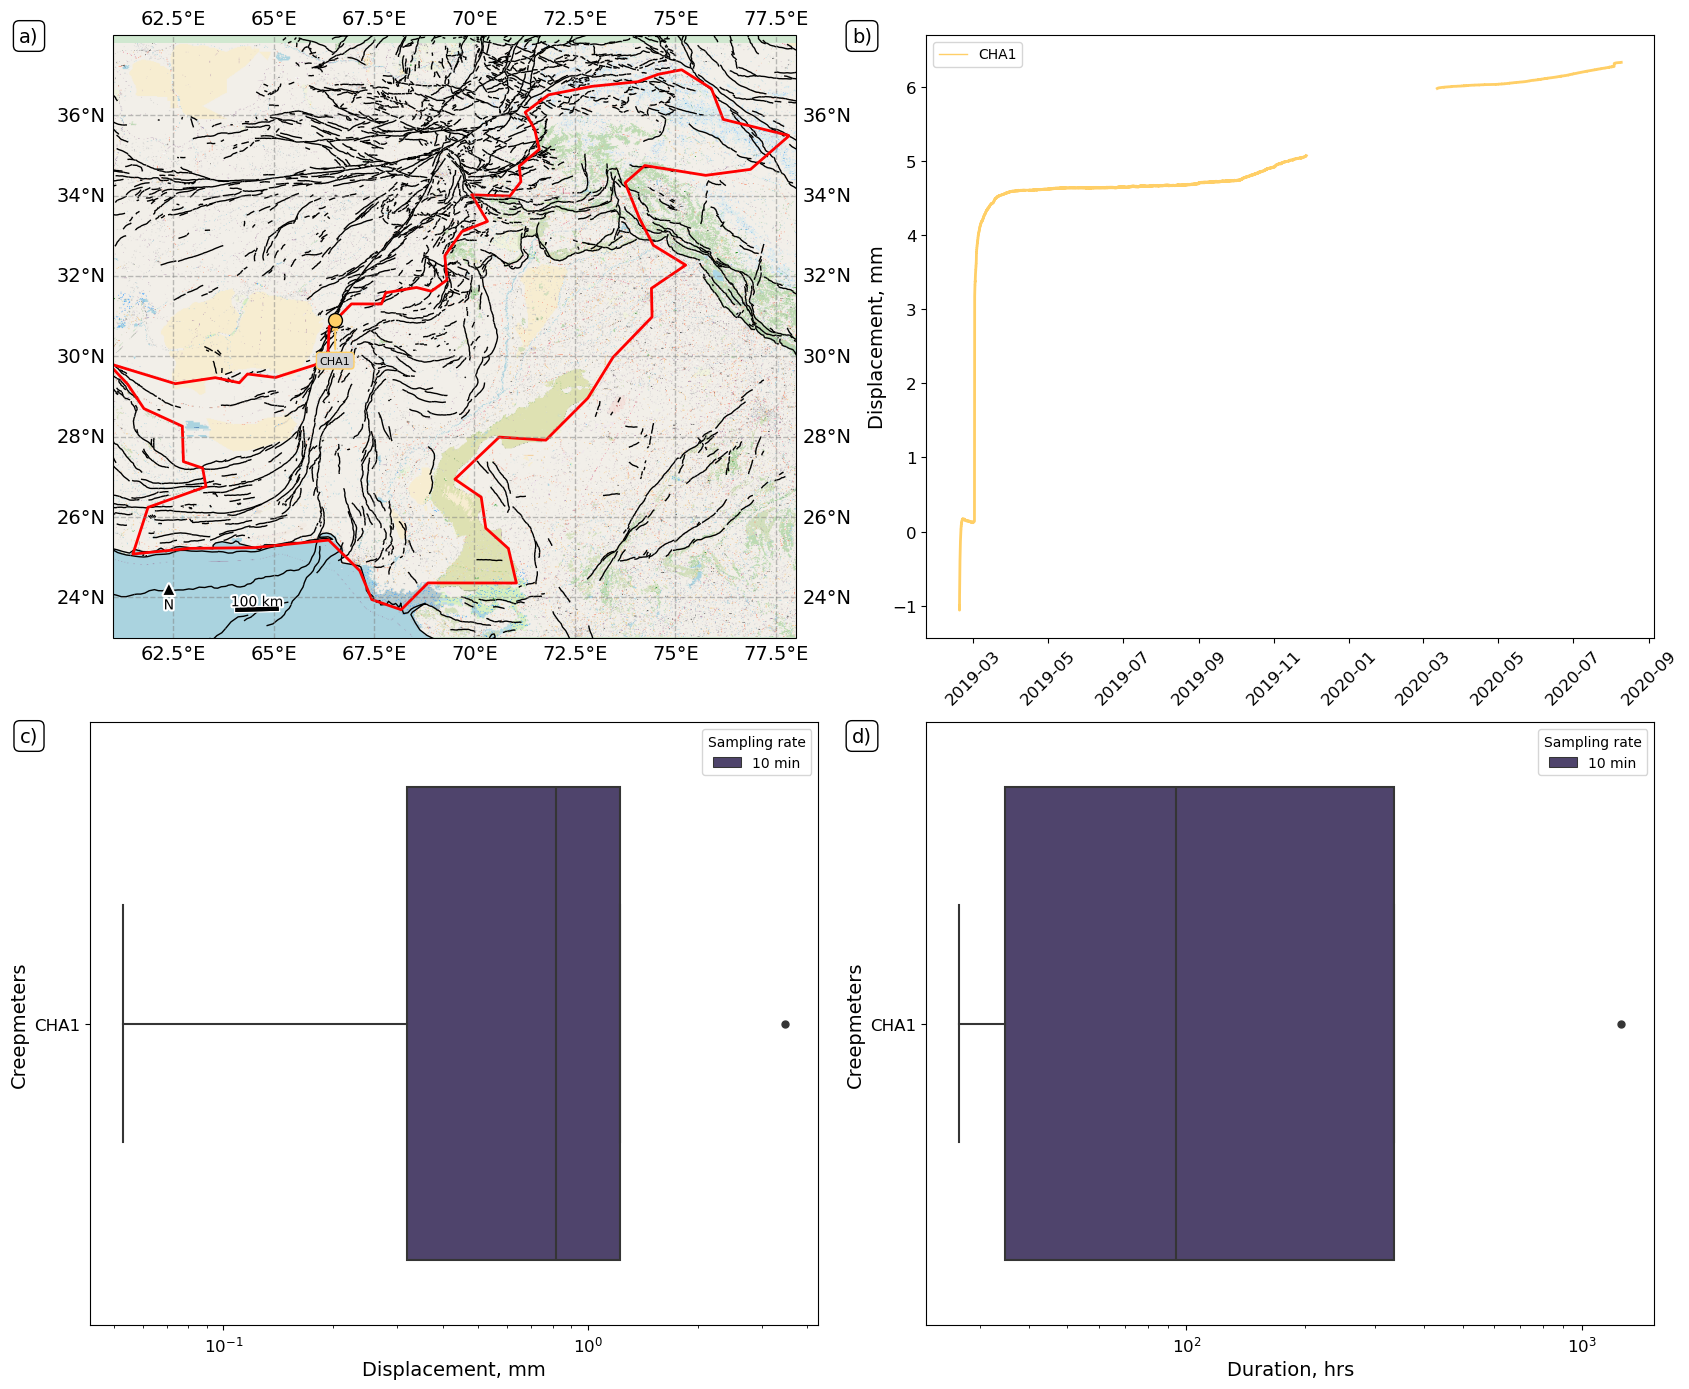

In [31]:
ce_summary_plot_Pakistan(df_all,Creepmeter_dataframe,'Chaman_Fault','Chaman','vertical',Pakistan,creepmeters_ls,cmc.managua,Pak,gdf_Asia)

In [14]:
def ce_summary_plot_Turkiye(creep_catalogue,instrument_database,region,save_name,shift,creepmeters_ls_list,creepmeters_ls,cmap,cm_map_list,gdf):
    turkiye_extent = [26.0, 45.0, 36.0, 42.5]
    sns.reset_defaults()

    region_CMs = instrument_database[instrument_database["Sub_region_map"]==region]
    file_codes = list(region_CMs["File_code"])
    order = list(region_CMs['Creepmeter_abbrv'].drop_duplicates())
    events_region = creep_catalogue[creep_catalogue["sub_region_maps"]==region]
    network = np.unique(region_CMs["Network"])
    events_region.sort_values(by="Latitude",inplace=True,ascending=False)
    events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
    events_region['Sampling rate'] = events_region['Sampling rate, mins'].astype(str)+' min'
    events_region_NAF = events_region.copy(deep=True)
    events_region_NAF.drop(events_region_NAF[events_region_NAF['Network']!='North_Anatolian_Fault'].index,inplace=True)
    events_region_EAF = events_region[events_region['Network']=='East_Anatolian_Fault']
    print(np.unique(events_region_NAF['Network']))
    order_NAF = list(events_region_NAF['Creepmeter_abbrv'].drop_duplicates())
    order_EAF = list(events_region_EAF['Creepmeter_abbrv'].drop_duplicates())


    try:
        slicedCM = cmap(np.linspace(0, 1, len(creepmeters_ls_list)))
    except:
        slicedCM = cmap(np.linspace(0, 1, 2))

    fig = plt.figure(figsize=(10, 10))

    ax1= plt.subplot(3, 3, 1, projection=ccrs.PlateCarree())
    # Create an instance of GoogleTiles
    # google_tiles = img_tiles.GoogleTiles(style='satellite')
    # Add the Google Tiles to the axis with a lower zoom level
    # ax1.add_image(google_tiles, 10)

    # Initialize OpenStreetMap tiles
    osm = img_tiles.OSM()

    # Add OpenStreetMap tiles to the plot
    ax1.add_image(osm, 10)  # Zoom level of 8  


    extent = turkiye_extent
    color_dict = {'creepmeter':{'INW1':rgb2hex(slicedCM[0]),
                                'ISW1':rgb2hex(slicedCM[1]),
                                'WSZ1':rgb2hex(slicedCM[2]),
                                'INW1/ISW1/WSZ1':rgb2hex(slicedCM[0]),
                                'SRI1':rgb2hex(slicedCM[3])}}
   
        
    # Add natural earth features for oceans and lakes
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face', facecolor='lightblue')
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face', facecolor='lightblue')
    # Add the land with pale sage green color
    pale_sage_green = '#D0E8D0'  # Very pale sage green color
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face', facecolor=pale_sage_green)

    # Add the features to the map
    ax1.add_feature(ocean, zorder=0)  # Add oceans first
    ax1.add_feature(lakes, zorder=1)  # Add lakes
    ax1.add_feature(land, zorder=0)   # Add land with pale sage green

    # Add coastlines and other features if desired
    ax1.coastlines(resolution='50m')
    # Load the Natural Earth countries shapefile
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

    # Filter for Pakistan
    turkiye = world[world.name == 'Turkey']

    # Add the outline of Pakistan
    turkiye.boundary.plot(ax=ax1, color='red', linewidth=2, transform=ccrs.PlateCarree())
    cm_plotter(ax1,cm_map_list,gdf,extent,color_dict,shift)
    

    ax2=plt.subplot(3,3,2)
    creepmeters_ls_list.reset_index(inplace=True,drop=True)    
    
    for i in range(len(creepmeters_ls_list)):
        boolarr = np.where(creepmeters_ls['Creepmeter_abbrv']==creepmeters_ls_list[i])[0]
        selected = creepmeters_ls.loc[boolarr]

        sample_freqs = [1,2,5,10,30,60]
        hatchings = ['*','O','||','++','.','XX']
        for j in range(len(selected)):
            duration = selected['diff'].iloc[j].days/365

            fcolour = color_dict['creepmeter'][selected['Creepmeter_abbrv'].iloc[j]]
            bool_hatch = np.where(sample_freqs==selected['Sampling rate, mins'].iloc[j])[0][0]
            hatch_style = hatchings[bool_hatch]
            y = ymd_to_ydec(selected['Start Time'].iloc[j])
            plt.broken_barh([(y,duration)],(i,0.5),facecolors=fcolour,\
                            edgecolors='black',hatch=hatch_style,zorder=i+1)

            
    sampling_freq_all = np.unique(region_CMs['Sampling rate, mins'])
    for k in range(len(sampling_freq_all)):
        bool_hatch = np.where(sample_freqs==sampling_freq_all[k])[0][0]
        hatch_style = hatchings[bool_hatch]
        ax2.add_patch(Rectangle((2024,0.25),0,0, fc ='white',  ec ='black',zorder=-1,hatch=hatch_style,\
                                label='{k} min'.format(k=sampling_freq_all[k])) )
    tick_locations = list(np.linspace(0.25,i+.25,i+1))
    plt.ylim([i+0.5,0])

    plt.yticks(tick_locations,list(creepmeters_ls_list),fontsize=12)

    plt.xticks(fontsize=12,rotation=45)
    
    plt.ylabel('Creepmeter',fontsize=14)
    left,right = ax2.get_xlim()
    plt.xlim(left,right)
    for axis in [ax2.xaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax2.legend(title='Sampling rate')

    sliced_palette = cmap(np.linspace(0, 1, 6))
    palette_new = {'1 min': rgb2hex(sliced_palette[0]), '2 min':rgb2hex(sliced_palette[1]),'5 min':rgb2hex(sliced_palette[2]),
               '10 min': rgb2hex(sliced_palette[3]),'30 min':rgb2hex(sliced_palette[4]), '60 min': rgb2hex(sliced_palette[5])}

    ax4 = plt.subplot(3,3,3)
    sns.countplot(events_region, x="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,order=order)
    ax4.set_xlabel('Creepmeters',fontsize=14)
    ax4.set_ylabel('Number of events',fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)

    ax3=plt.subplot(3,3,4)
    ax3.set_ylabel("Displacement, mm",fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)
    
    ax7 = plt.subplot(3,3,7)
    ax7.set_ylabel("Displacement, mm",fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)


    for i in range(len(file_codes)):
        print(file_codes[i])
        for j in range(len(network)):
            try:
                path = "../../Data/{p}/SAC/{q}.SAC".format(p=network[j],q =file_codes[i])
                st = obspy.read(path)
                tr = st[0]
                #tr.interpolate(sampling_rate=tr.stats.sampling_rate)
                tm = tr.times("utcdatetime")
                creep = tr.data
                sample_rate =  round(tr.stats.delta)/60
                tm_dt = []
                for w in range(len(tm)):
                    tm_new = tm[w].datetime
                    tm_dt.append(tm_new)
                file_loc = np.where(instrument_database["File_code"]==file_codes[i])

                #label = instrument_database["Creepmeter_abbrv"].loc[file_loc[0][0]] + ": " + \
                    #str(instrument_database["Sampling rate, mins"].loc[file_loc[0][0]]) + "mins"  
                
                if instrument_database["Sampling rate, mins"].loc[file_loc[0][0]] ==10:
                    foreground='grey'
                else:
                    foreground = 'black'
                if network[j] == 'North_Anatolian_Fault':
                    ax3.plot(tm_dt,creep,color=color_dict['creepmeter'][instrument_database['Creepmeter_abbrv'].loc[file_loc[0][0]]],
                            linewidth=2)#,path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
                    
                if network[j] == 'East_Anatolian_Fault':
                    ax7.plot(tm_dt,creep,color=color_dict['creepmeter'][instrument_database['Creepmeter_abbrv'].loc[file_loc[0][0]]],
                            linewidth=2)#,path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])


            except FileNotFoundError:
                dummy=10
    
    NAF_stations = np.unique(events_region_NAF['Creepmeter_abbrv'])
    EAF_stations = np.unique(events_region_EAF['Creepmeter_abbrv'])
    for k in range(len(NAF_stations)):
        ax3.plot([],[],color=color_dict['creepmeter'][NAF_stations[k]],linewidth=2,label = NAF_stations[k] )

    for p in range(len(events_region_EAF)):
        ax3.plot([],[],color=color_dict['creepmeter'][EAF_stations[p]],linewidth=2,label = EAF_stations[p] ) 
    
    ax3.legend()    
    ax7.legend()
    

    ax5 = plt.subplot(3,3,5)
    sns.boxplot(data=events_region_NAF, x="Displacement, mm", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,\
                order=order_NAF,flierprops={"marker": "o"})
    ax5.set_ylabel('Creepmeters',fontsize=14)
    ax5.set_xlabel('Displacement, mm',fontsize=14)
    ax5.set_xscale('log')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    ax6 = plt.subplot(3,3,6)
    sns.boxplot(data=events_region_NAF, x="Duration, hrs", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,\
                order=order_NAF,flierprops={"marker": "o"})
    ax6.set_xscale('log')
    ax6.set_ylabel('Creepmeters',fontsize=14)
    ax6.set_xlabel('Duration, hrs',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    ax8 = plt.subplot(3,3,8)
    ax8.set_ylabel('Creepmeters',fontsize=14)
    ax8.set_xlabel('Displacement, mm',fontsize=14)
    ax8.set_xscale('log')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    '''sns.boxplot(data=events_region_EAF, x="Displacement, mm", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,\
                order=order,flierprops={"marker": "o"})'''
    

    ax9 = plt.subplot(3,3,9)
    ax9.set_xscale('log')
    ax9.set_ylabel('Creepmeters',fontsize=14)
    ax9.set_xlabel('Duration, hrs',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    '''sns.boxplot(data=events_region_EAF, x="Duration, hrs", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette_new,\
                order=order,flierprops={"marker": "o"})
    '''
    
    fig.tight_layout()
    fig.text(0.02,0.97,'a)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.35,0.97,'b)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.70,0.97,'c)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.02,0.65,'d)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.35,0.65,'e)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.70,0.65,'f)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.02,0.33,'g)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.35,0.33,'h)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.70,0.33,'i)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.savefig("../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.pdf".format(k=save_name))
    fig.savefig("../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.png".format(k=save_name))

    plt.show()


    return

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/642454589.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/642454589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_36069/642454589.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

['North_Anatolian_Fault']


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 wi

sri_0
inw_0
inw_1
isw_0
wsz_0
wsz_1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


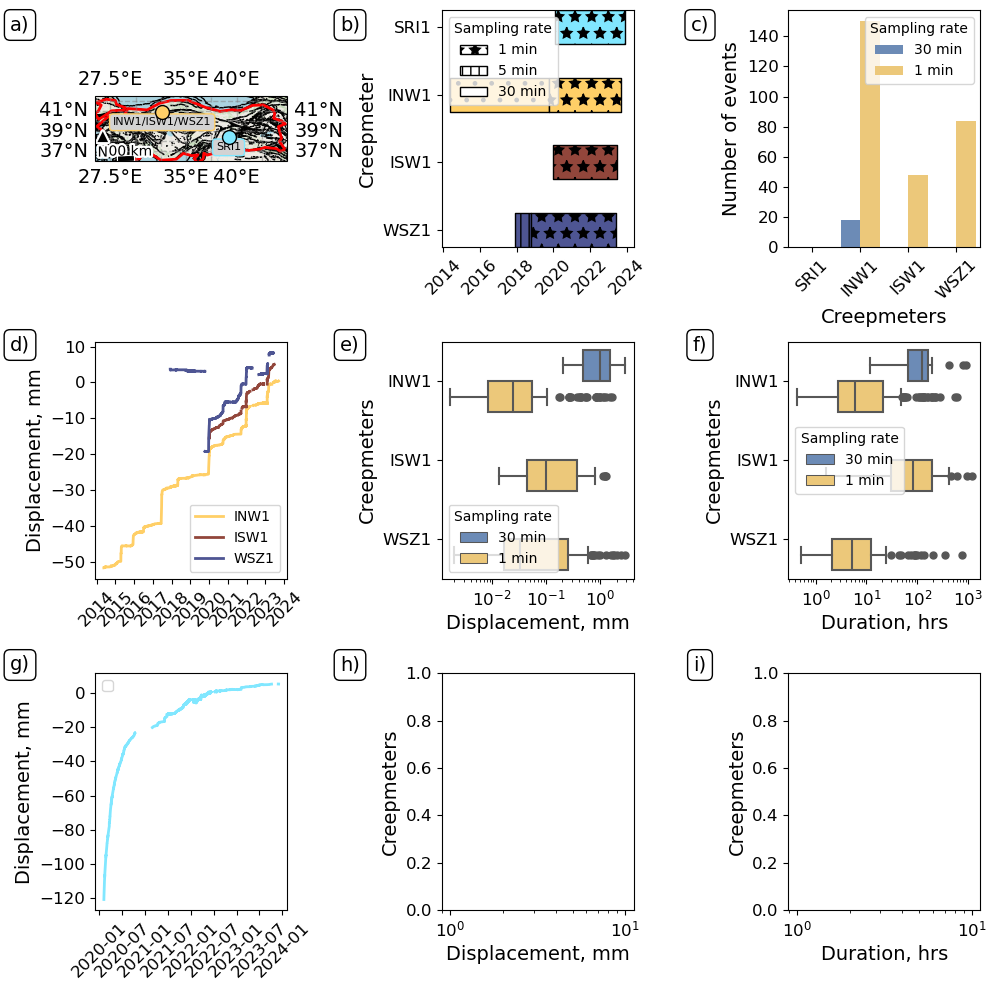

In [15]:
ce_summary_plot_Turkiye(df_all,Creepmeter_dataframe,'Turkiye','Turkiye','vertical',Turkey,creepmeters_ls,cmc.managua,Turk_cropped,gdf_Asia)

In [ ]:


# Create a figure with two subplots (1 row, 2 columns)
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust space between subplots
plt.subplots_adjust(wspace=0.2)

# Load the Natural Earth data for country boundaries
shapefile_countries = natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
shapefile_states = natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces')

# Add labels to the subplots
fig.text(-0.1, 1.1, 'a)', transform=ax_left.transAxes, fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax_right.text(-0.1, 0.8, 'b)', transform=ax_right.transAxes, fontsize=12,
              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# --------------------------- Left Panel (World Map) --------------------------- #
ax_left.coastlines()
ax_left.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

# Highlight specific countries on the map
for country in Reader(shapefile_countries).records():
    country_name = country.attributes['NAME']
    if country_name == 'Turkey':
        ax_left.add_geometries([country.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='blue', linewidth=1.5)
    elif country_name == 'Pakistan':
        ax_left.add_geometries([country.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='red', linewidth=1.5)
    else:
        ax_left.add_geometries([country.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='beige', linewidth=0.5)

# Highlight California in the world map
for state in Reader(shapefile_states).records():
    state_name = state.attributes['name']
    country_code = state.attributes['adm0_a3']
    if state_name == 'California' and country_code == 'USA':
        ax_left.add_geometries([state.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='purple', linewidth=1.5)

ax_left.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax_left.set_global()

# ------------------------- Right Panel (California Only) ------------------------- #
ax_right.set_extent([-125.0, -114.0, 32.0, 42.0])
ax_right.set_facecolor('white')

# Set the axis spines to be white and hide the ticks
for spine in ax_right.spines.values():
    spine.set_color('white')
    spine.set_linewidth(0.5)  # Optional: set spine line width

ax_right.tick_params(labelcolor='white')

# Fill California with beige
for state in Reader(shapefile_states).records():
    state_name = state.attributes['name']
    country_code = state.attributes['adm0_a3']
    if state_name == 'California' and country_code == 'USA':
        ax_right.add_geometries([state.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='beige', linewidth=1.5)

# Make the California outline more prominent
ax_right.add_geometries([state.geometry], ccrs.PlateCarree(), edgecolor='darkblue', facecolor='none', linewidth=2)



# Add Fault geometries
ax_right.add_geometries(gdf.geometry, crs = ccrs.PlateCarree(),edgecolor='black', facecolor="none")

# Define box colours
cmap = cmc.hawaii
slicedCM = cmap(np.linspace(0,1,4))
print(rgb2hex(slicedCM[0]),rgb2hex(slicedCM[1]),rgb2hex(slicedCM[2]),rgb2hex(slicedCM[3]))
# Define colors and labels for regions
regions = {
    'Hayward': {'coords': dict(left=-122.4, bottom=37.5, right=-121.8, top=38), 'color': slicedCM[0], 'label': 'fig\n3a.'},
    'Hollister': {'coords': dict(left=-121.75, bottom=36.5, right=-121.0, top=37.0), 'color': slicedCM[1], 'label': 'fig\n4a.'},
    'Parkfield': {'coords': dict(left=-120.75, bottom=35.65, right=-120.1, top=36.1), 'color': slicedCM[2], 'label': 'fig\n5a.'},
    'Salton Sea': {'coords': dict(left=-116.25, bottom=32.5, right=-115.25, top=33.5), 'color': slicedCM[3], 'label': 'fig\n6a.'},
}

label_distance = 1.6  # Distance from the box for text labels
text_box_color = 'lightgrey'
alpha_inner = 0.9  # Alpha for the inner box

# Loop through each region to create bounding boxes and annotations
for region, props in regions.items():
    coords = props['coords']
    color = props['color']
    label = props['label']

    # Create and add bounding box
    bbox = box(coords['left'], coords['bottom'], coords['right'], coords['top'])
    ax_right.add_geometries([bbox], ccrs.PlateCarree(), edgecolor=color, facecolor='lightgrey', linestyle='-', linewidth=2, alpha=alpha_inner)

    # Calculate label position
    label_y = (coords['top'] + coords['bottom']) / 2
    label_x = coords['right'] + label_distance if region != 'Salton Sea' else coords['left'] - label_distance

    # Add annotation
    ax_right.annotate(region, 
                      xy=(coords['right'] if region != 'Salton Sea' else coords['left'], label_y),
                      xytext=(label_x, label_y),
                      arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
                      bbox=dict(boxstyle='round,pad=0.3', edgecolor=color, facecolor=text_box_color),
                      fontsize=10, ha='center', va='center')

    # Add text inside the bounding box
    box_x_center = (coords['left'] + coords['right']) / 2
    ax_right.text(box_x_center, label_y, label, fontsize=8, ha='center', va='center', color='black')

scale_bar(ax_right, ccrs.PlateCarree(), 100)

# --------------------------- Display the Plot --------------------------- #
fig.set_size_inches(17, 12)
plt.savefig("../../Creep_catalog_stats_figures/Creepmeter_locations_world.pdf")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import img_tiles

# Create a figure with a Mercator projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})

# Set the extent to focus on Pakistan
ax.set_extent([60.8728, 77.0650, 23.6345, 37.0841])  # [lon_min, lon_max, lat_min, lat_max]

# Initialize OpenStreetMap tiles
osm = img_tiles.OSM()

# Add OpenStreetMap tiles to the plot
ax.add_image(osm, 8)  # Zoom level of 8

# Add natural earth features for oceans and lakes
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                    edgecolor='face', facecolor='lightblue')
lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                    edgecolor='face', facecolor='lightblue')
# Add the land with pale sage green color
pale_sage_green = '#D0E8D0'  # Very pale sage green color
land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                edgecolor='face', facecolor=pale_sage_green)

# Add the features to the map
ax.add_feature(ocean, zorder=0)  # Add oceans first
ax.add_feature(lakes, zorder=1)  # Add lakes
ax.add_feature(land, zorder=0)   # Add land with pale sage green

# Load the Natural Earth countries shapefile
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Filter for Pakistan
pakistan = world[world.name == 'Pakistan']

# Add the outline of Pakistan
pakistan.boundary.plot(ax=ax, color='red', linewidth=2, transform=ccrs.PlateCarree())


# Add gridlines with labels
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Add a title
ax.add_geometries(gdf_Asia.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")

# Show the plot
plt.show()


In [6]:
path = "../../Data/{p}/SAC/{q}.SAC".format(p='North_Anatolian_Fault',q ='isw_0')
st = obspy.read(path)
tr = st[0]

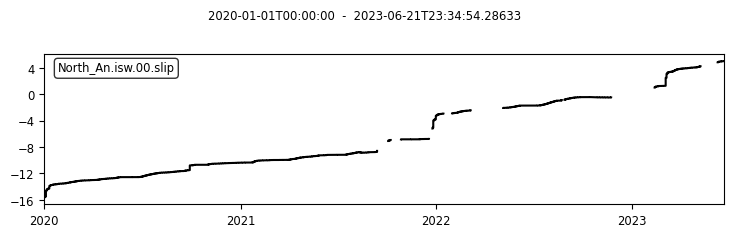

In [7]:
tr.plot();

In [5]:
tr.stats

         network: Central_
         station: xmr
        location: 00
         channel: slip
       starttime: 1980-01-30T00:00:00.000000Z
         endtime: 2014-03-11T20:29:33.932453Z
   sampling_rate: 0.0016666667070239782
           delta: 599.9999854713682
            npts: 1794220
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 600.0, 'depmin': 5.088, 'depmax': 569.394, 'scale': 1.0, 'b': 0.0, 'e': 1076531500.0, 'depmen': nan, 'nzyear': 1980, 'nzjday': 30, 'nzhour': 0, 'nzmin': 0, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 1794220, 'iftype': 1, 'iztype': 9, 'leven': 1, 'lpspol': 1, 'lovrok': 1, 'lcalda': 0, 'kstnm': 'xmr', 'khole': '00', 'kcmpnm': 'slip', 'knetwk': 'Central_'})